In [ ]:
##DECOMPOSITION of video frames 14/03/2021
import sys
import shutil

import numpy as np
from math import floor
import pandas as pd
import numpy as np
import cv2

import os
import time
from PIL import Image
import math

# command line arguments --> file name, video_file_name, gpu or cpu 


# first decompose the video to frames
# place the video to be detected into the directory


#video = sys.argv[1]
#pred_text_file_name = sys.argv[2]

# resize image
#output = cv2.resize(src, dsize)


start = time.time()
text_file = 'frames.txt'

print('decomposing video to frames this may take a while  for large videos :) .....')
frames_path = 'video_frames/'
os.makedirs('video_frames/', exist_ok=True)
#os.makedirs('predictions/', exist_ok=True)

f = open(text_file, 'w+')
# Opens the Video file
cap= cv2.VideoCapture('/content/NAD57.mpg')
i=1
while(cap.isOpened()):
    ret, frame = cap.read()
    if ret == False:
        break
    scale_percent = 25

#calculate the 50 percent of original dimensions
    width = int(frame.shape[1] * scale_percent / 100)
    height = int(frame.shape[0] * scale_percent / 100)

# dsize
    dsize = (width, height)

    output = cv2.resize(frame, dsize) 
    frame_path = frames_path + 'frame_' + str(i) + '.jpg'
    cv2.imwrite("/content/video_frames/frame_"+ str(i) + ".jpg", output)
    f.write(frame_path + '\n')
    i+=1

cap.release()
cv2.destroyAllWindows()
print("decomposition complete")

end = time.time()
# total time taken
print(f"Runtime of the program is {end - start}")

decomposing video to frames this may take a while  for large videos :) .....
decomposition complete
Runtime of the program is 9.847248554229736


In [ ]:
#CIEDE2000 frame sequence difference 14/03/2021 ORIGINAL PAPER
import cv2
import numpy as np
from skimage import color
#from ciede2000 import CIEDE2000
import math
import time
from matplotlib import pyplot as plt
import numpy as np

def CIEDE2000(Lab_1, Lab_2):
    '''Calculates CIEDE2000 color distance between two CIE L*a*b* colors'''
    C_25_7 = 6103515625 # 25**7
    
    L1, a1, b1 = Lab_1[0], Lab_1[1], Lab_1[2]
    L2, a2, b2 = Lab_2[0], Lab_2[1], Lab_2[2]
    C1 = math.sqrt(a1**2 + b1**2)
    C2 = math.sqrt(a2**2 + b2**2)
    C_ave = (C1 + C2) / 2
    G = 0.5 * (1 - math.sqrt(C_ave**7 / (C_ave**7 + C_25_7)))
    
    L1_, L2_ = L1, L2
    a1_, a2_ = (1 + G) * a1, (1 + G) * a2
    b1_, b2_ = b1, b2
    
    C1_ = math.sqrt(a1_**2 + b1_**2)
    C2_ = math.sqrt(a2_**2 + b2_**2)
    
    if b1_ == 0 and a1_ == 0: h1_ = 0
    elif a1_ >= 0: h1_ = math.atan2(b1_, a1_)
    else: h1_ = math.atan2(b1_, a1_) + 2 * math.pi
    
    if b2_ == 0 and a2_ == 0: h2_ = 0
    elif a2_ >= 0: h2_ = math.atan2(b2_, a2_)
    else: h2_ = math.atan2(b2_, a2_) + 2 * math.pi

    dL_ = L2_ - L1_
    dC_ = C2_ - C1_    
    dh_ = h2_ - h1_
    if C1_ * C2_ == 0: dh_ = 0
    elif dh_ > math.pi: dh_ -= 2 * math.pi
    elif dh_ < -math.pi: dh_ += 2 * math.pi        
    dH_ = 2 * math.sqrt(C1_ * C2_) * math.sin(dh_ / 2)
    
    L_ave = (L1_ + L2_) / 2
    C_ave = (C1_ + C2_) / 2
    
    _dh = abs(h1_ - h2_)
    _sh = h1_ + h2_
    C1C2 = C1_ * C2_
    
    if _dh <= math.pi and C1C2 != 0: h_ave = (h1_ + h2_) / 2
    elif _dh  > math.pi and _sh < 2 * math.pi and C1C2 != 0: h_ave = (h1_ + h2_) / 2 + math.pi
    elif _dh  > math.pi and _sh >= 2 * math.pi and C1C2 != 0: h_ave = (h1_ + h2_) / 2 - math.pi 
    else: h_ave = h1_ + h2_
    
    T = 1 - 0.17 * math.cos(h_ave - math.pi / 6) + 0.24 * math.cos(2 * h_ave) + 0.32 * math.cos(3 * h_ave + math.pi / 30) - 0.2 * math.cos(4 * h_ave - 63 * math.pi / 180)
    
    h_ave_deg = h_ave * 180 / math.pi
    if h_ave_deg < 0: h_ave_deg += 360
    elif h_ave_deg > 360: h_ave_deg -= 360
    dTheta = 30 * math.exp(-(((h_ave_deg - 275) / 25)**2))
    
    R_C = 2 * math.sqrt(C_ave**7 / (C_ave**7 + C_25_7))  
    S_C = 1 + 0.045 * C_ave
    S_H = 1 + 0.015 * C_ave * T
    
    Lm50s = (L_ave - 50)**2
    S_L = 1 + 0.015 * Lm50s / math.sqrt(20 + Lm50s)
    R_T = -math.sin(dTheta * math.pi / 90) * R_C

    k_L, k_C, k_H = 1, 1, 1
    
    f_L = dL_ / k_L / S_L
    f_C = dC_ / k_C / S_C
    f_H = dH_ / k_H / S_H
    
    dE_00 = math.sqrt(f_L**2 + f_C**2 + f_H**2 + R_T * f_C * f_H)
    return dE_00
#start time
start = time.time()
frame = []
labdiff = []
for k in range(1,12510):
  image1 = cv2.imread("/content/video_frames/frame_"+ str(k) + ".jpg")
  image2 = cv2.imread("/content/video_frames/frame_"+ str(k+1) + ".jpg")
  image1 = np.float32(image1)
  image1 *= 1./255
  image2 = np.float32(image2)
  image2 *= 1./255

  Lab1 = cv2.cvtColor(image1, cv2.COLOR_BGR2Lab)
  print(Lab1.shape)
  Lab2 = cv2.cvtColor(image2, cv2.COLOR_BGR2Lab)


  L1, a1, b1 = cv2.split(Lab1)
  L2, a2, b2 = cv2.split(Lab2)

#print(np.mean(L1))
#print(a1)
  diff = 0
  for i in range(0,Lab1.shape[0]):
    for j in range(0,Lab1.shape[1]):
      diff = diff + CIEDE2000((L1[i][j], a1[i][j], b1[i][j]), (L2[i][j], a2[i][j], b2[i][j]))
    #print(CIEDE2000((L1[i][j], a1[i][j], b1[i][j]), (L2[i][j], a2[i][j], b2[i][j])))
  print(k)
  print(k+1)
  print(diff/(60*88*3))
  frame.append(k)
  labdiff.append(diff/(60*88*3))
#print(CIEDE2000((50, 2.6772, -79.7751), (50, 0.0000, -82.7485)))


#plt.plot([0.1, 0.2, 0.3, 0.4], [1, 2, 3, 4])
#plt.plot([0.1, 0.2, 0.3, 0.4], [1, 4, 9, 16])
frame = np.array(frame)
labdiff = np.array(labdiff)#*(240*352*3)
labdiff = labdiff/max(labdiff)
print(max(labdiff))
print(labdiff)
plt.plot(frame, (labdiff))#, label='CIEDE2000 Lab Difference')
plt.xlabel("Frame Sequence")
plt.ylabel("CIE2000 Lab Difference")
plt.legend()
#plt.savefig('labdiff.jpeg')
#print(labdiff[11732]*3)
#print(labdiff[11733]*3)
#print(labdiff[11734]*3)

ab_cut = []
deli = 0.22
#labdiff = labdiff*max(labdiff)
for i in range(2,len(frame)):
  if(labdiff[i] > deli):
    if(labdiff[i-1] < deli):
      if(labdiff[i+1] < deli):
        ab_cut.append(i+139)

print(len(ab_cut))
print(ab_cut)
ab_cut = np.array(ab_cut)
print(ab_cut)
#print(ab_cut[0])

sl = []
with open("/content/ab_cut_gt.txt", 'r') as fileobj:
    for row in fileobj:
      sl.append(row.rstrip('\n'))
        #print( row.rstrip('\n') )
print(sl)
print(len(sl))
sl = np.array(sl)
print(sl[0])

gt = []

for i in range(0,len(sl)):
  gt.append(np.int(sl[i]))

print(gt)


TP = 0
FN = 0
FP = 0

num = 0

for i in range(0, len(gt)):
  num = gt[i]
  if num in ab_cut:
    TP = TP + 1
  else:
    FN = FN + 1

for i in range(0,len(ab_cut)):
  num = ab_cut[i]
  if num in gt:
    TP = TP + 1
  else:
    FP = FP + 1




Recall = TP/(TP+FN)

Precision = TP/(TP + FP)

F1 = 2*(Recall*Precision)/(Precision + Recall)
print("RECALL")
print(Recall)

print("PRECISION")
print(Precision)

print("F1 Score")
print(F1)





# end time
end = time.time()

# total time taken
print(f"Runtime of the program is {end - start}")




In [ ]:
import cv2
import numpy as np
from skimage import color
from matplotlib import pyplot as plt



k = 1540 - 139
image1 = cv2.imread("/content/video_frames/frame_"+ str(k) + ".jpg")
image2 = cv2.imread("/content/video_frames/frame_"+ str(k+1) + ".jpg")
image1 = np.float32(image1)
image1 *= 1./255
image2 = np.float32(image2)
image2 *= 1./255

Lab1 = cv2.cvtColor(image1, cv2.COLOR_BGR2Lab)
print(Lab1.shape)
Lab2 = cv2.cvtColor(image2, cv2.COLOR_BGR2Lab)


L1, a1, b1 = cv2.split(Lab1)
L2, a2, b2 = cv2.split(Lab2)

print(L1)

print(a1)

print(b1)

pixdiff = []
pixno = []

p = 0
for i in range(0,Lab1.shape[0]):
    for j in range(0,Lab1.shape[1]):
      diff = CIEDE2000((L1[i][j], a1[i][j], b1[i][j]), (L2[i][j], a2[i][j], b2[i][j]))
      pixdiff.append(diff)
      p = p + 1
      pixno.append(p)

print(pixno)
print(pixdiff) 
#print(np.mean(pixdiff))

#plt.plot([0.1, 0.2, 0.3, 0.4], [1, 2, 3, 4])
#plt.plot([0.1, 0.2, 0.3, 0.4], [1, 4, 9, 16])
#frame = np.array(pixno)
labdiff = np.array(pixdiff)#*(240*352*3)
z = np.count_nonzero(labdiff)
print(z)
#labdiff = labdiff/max(labdiff)
#print(max(labdiff))
#plt.plot(frame, (labdiff))#, label='CIEDE2000 Lab Difference')
#plt.xlabel("Pixel Sequence")
#plt.ylabel("CIE2000 Pix Difference")
#plt.legend()

#print(labdiff.sort())
#print(labdiff)
#print(labdiff[len(labdiff)-1]-labdiff[len(labdiff)-2])
#plt.savefig('labdiffpix1330.jpeg')
#print(labdiff[11732]*3)
#print(labdiff[11733]*3)
#print(labdiff[11734]*3)



#Ld1 = []
#ad1 = []
#bd1 = []
#for i in range(0,image1.shape[0]):
#  for j in range(0,image1.shape[1]):
#    Ld1.append(L1[i][j])
#    ad1.append(a1[i][j])
#    bd1.append(b1[i][j])

#Ld1 = np.array(Ld1)
#ad1 = np.array(ad1)
#bd1 = np.array(bd1)

#mat = {}
#mat['L'] = Ld1
#mat['a'] = ad1
#mat['b'] = bd1



#feat = np.stack((Ld1, ad1, bd1), axis = 1)

#print(feat)


(60, 88, 3)
[[ 0.390625    0.390625    0.6591797  ...  7.019043    6.3049316
  10.699463  ]
 [ 0.390625    0.390625    0.6591797  ...  5.7250977   5.2368164
   9.185791  ]
 [ 0.3479004   0.3479004   0.4638672  ...  6.8725586   6.4086914
  10.137939  ]
 ...
 [ 0.45166016  0.45166016  0.45166016 ...  2.0690918   2.331543
   1.184082  ]
 [ 0.45166016  0.45166016  0.37231445 ...  2.0690918   2.0202637
   0.92163086]
 [ 0.45166016  0.45166016  0.37231445 ...  2.380371    2.331543
   0.92163086]]
[[1.84375  1.84375  1.84375  ... 7.703125 4.875    3.375   ]
 [1.84375  1.84375  1.84375  ... 7.015625 4.890625 3.4375  ]
 [1.5625   1.5625   2.078125 ... 8.984375 7.28125  5.171875]
 ...
 [0.9375   0.9375   0.9375   ... 5.5      4.265625 2.75    ]
 [0.9375   0.9375   1.859375 ... 5.5      4.109375 2.859375]
 [0.9375   0.9375   1.859375 ... 5.65625  4.265625 2.859375]]
[[-0.203125 -0.203125 -0.203125 ...  7.796875  6.265625  7.71875 ]
 [-0.203125 -0.203125 -0.203125 ...  7.0625    5.890625  7.3125  

In [ ]:
#CIEDE2000 frame sequence difference 14/03/2021 ORIGINAL PAPER
import cv2
import numpy as np
from skimage import color
#from ciede2000 import CIEDE2000
import math
import time
from matplotlib import pyplot as plt
import numpy as np

def CIEDE2000(Lab_1, Lab_2):
    '''Calculates CIEDE2000 color distance between two CIE L*a*b* colors'''
    C_25_7 = 6103515625 # 25**7
    
    L1, a1, b1 = Lab_1[0], Lab_1[1], Lab_1[2]
    L2, a2, b2 = Lab_2[0], Lab_2[1], Lab_2[2]
    C1 = math.sqrt(a1**2 + b1**2)
    C2 = math.sqrt(a2**2 + b2**2)
    C_ave = (C1 + C2) / 2
    G = 0.5 * (1 - math.sqrt(C_ave**7 / (C_ave**7 + C_25_7)))
    
    L1_, L2_ = L1, L2
    a1_, a2_ = (1 + G) * a1, (1 + G) * a2
    b1_, b2_ = b1, b2
    
    C1_ = math.sqrt(a1_**2 + b1_**2)
    C2_ = math.sqrt(a2_**2 + b2_**2)
    
    if b1_ == 0 and a1_ == 0: h1_ = 0
    elif a1_ >= 0: h1_ = math.atan2(b1_, a1_)
    else: h1_ = math.atan2(b1_, a1_) + 2 * math.pi
    
    if b2_ == 0 and a2_ == 0: h2_ = 0
    elif a2_ >= 0: h2_ = math.atan2(b2_, a2_)
    else: h2_ = math.atan2(b2_, a2_) + 2 * math.pi

    dL_ = L2_ - L1_
    dC_ = C2_ - C1_    
    dh_ = h2_ - h1_
    if C1_ * C2_ == 0: dh_ = 0
    elif dh_ > math.pi: dh_ -= 2 * math.pi
    elif dh_ < -math.pi: dh_ += 2 * math.pi        
    dH_ = 2 * math.sqrt(C1_ * C2_) * math.sin(dh_ / 2)
    
    L_ave = (L1_ + L2_) / 2
    C_ave = (C1_ + C2_) / 2
    
    _dh = abs(h1_ - h2_)
    _sh = h1_ + h2_
    C1C2 = C1_ * C2_
    
    if _dh <= math.pi and C1C2 != 0: h_ave = (h1_ + h2_) / 2
    elif _dh  > math.pi and _sh < 2 * math.pi and C1C2 != 0: h_ave = (h1_ + h2_) / 2 + math.pi
    elif _dh  > math.pi and _sh >= 2 * math.pi and C1C2 != 0: h_ave = (h1_ + h2_) / 2 - math.pi 
    else: h_ave = h1_ + h2_
    
    T = 1 - 0.17 * math.cos(h_ave - math.pi / 6) + 0.24 * math.cos(2 * h_ave) + 0.32 * math.cos(3 * h_ave + math.pi / 30) - 0.2 * math.cos(4 * h_ave - 63 * math.pi / 180)
    
    h_ave_deg = h_ave * 180 / math.pi
    if h_ave_deg < 0: h_ave_deg += 360
    elif h_ave_deg > 360: h_ave_deg -= 360
    dTheta = 30 * math.exp(-(((h_ave_deg - 275) / 25)**2))
    
    R_C = 2 * math.sqrt(C_ave**7 / (C_ave**7 + C_25_7))  
    S_C = 1 + 0.045 * C_ave
    S_H = 1 + 0.015 * C_ave * T
    
    Lm50s = (L_ave - 50)**2
    S_L = 1 + 0.015 * Lm50s / math.sqrt(20 + Lm50s)
    R_T = -math.sin(dTheta * math.pi / 90) * R_C

    k_L, k_C, k_H = 1, 1, 1
    
    f_L = dL_ / k_L / S_L
    f_C = dC_ / k_C / S_C
    f_H = dH_ / k_H / S_H
    
    dE_00 = math.sqrt(f_L**2 + f_C**2 + f_H**2 + R_T * f_C * f_H)
    return dE_00
#start time
start = time.time()
frame = []
labdiff = []
for k in range(1,100):
  image1 = cv2.imread("/content/video_frames/frame_"+ str(k) + ".jpg")
  image2 = cv2.imread("/content/video_frames/frame_"+ str(k+1) + ".jpg")
  image1 = np.float32(image1)
  image1 *= 1./255
  image2 = np.float32(image2)
  image2 *= 1./255

  Lab1 = cv2.cvtColor(image1, cv2.COLOR_BGR2Lab)
  print(Lab1.shape)
  Lab2 = cv2.cvtColor(image2, cv2.COLOR_BGR2Lab)


  L1, a1, b1 = cv2.split(Lab1)
  L2, a2, b2 = cv2.split(Lab2)

#print(np.mean(L1))
#print(a1)
  diff = 0
  for i in range(0,Lab1.shape[0]):
    for j in range(0,Lab1.shape[1]):

      #diff = CIEDE2000((L1[i][j], a1[i][j], b1[i][j]), (L2[i][j], a2[i][j], b2[i][j]))
      diff = diff + CIEDE2000((L1[i][j], a1[i][j], b1[i][j]), (L2[i][j], a2[i][j], b2[i][j])) 
    #print(CIEDE2000((L1[i][j], a1[i][j], b1[i][j]), (L2[i][j], a2[i][j], b2[i][j])))
  print(k)
  print(k+1)
  print(diff/(60*88*3))
  frame.append(k)
  labdiff.append(diff/(60*88*3))

print(labdiff)



# end time
end = time.time()

# total time taken
print(f"Runtime of the program is {end - start}")



(60, 88, 3)
1
2
0.7973700344804119
(60, 88, 3)
2
3
0.6678028301571849
(60, 88, 3)
3
4
0.7800954297853963
(60, 88, 3)
4
5
0.7800781772896781
(60, 88, 3)
5
6
0.5941973497139073
(60, 88, 3)
6
7
0.6014040879639568
(60, 88, 3)
7
8
0.6685625976435052
(60, 88, 3)
8
9
0.5588103729288899
(60, 88, 3)
9
10
0.5654481405372201
(60, 88, 3)
10
11
0.609988471493852
(60, 88, 3)
11
12
0.47968375129737717
(60, 88, 3)
12
13
0.6461290880035582
(60, 88, 3)
13
14
0.5971326795348534
(60, 88, 3)
14
15
0.5014143680299703
(60, 88, 3)
15
16
0.554809143429761
(60, 88, 3)
16
17
0.5932077259865244
(60, 88, 3)
17
18
0.4838105084861479
(60, 88, 3)
18
19
0.472500857122115
(60, 88, 3)
19
20
0.5350098438097356
(60, 88, 3)
20
21
0.3872144917212039
(60, 88, 3)
21
22
0.43073836917399166
(60, 88, 3)
22
23
0.3991513403406167
(60, 88, 3)
23
24
0.2810178137406685
(60, 88, 3)
24
25
0.3040309504736184
(60, 88, 3)
25
26
0.31610093732161243
(60, 88, 3)
26
27
0.2607993099753258
(60, 88, 3)
27
28
0.2826516652415342
(60, 88, 3)
28
29


In [ ]:
#CIEDE2000 frame sequence difference 14/03/2021 ORIGINAL PAPER with 
#concept of non zero elements
import cv2
import numpy as np
from skimage import color
#from ciede2000 import CIEDE2000
import math
import time
from matplotlib import pyplot as plt
import numpy as np

def CIEDE2000(Lab_1, Lab_2):
    '''Calculates CIEDE2000 color distance between two CIE L*a*b* colors'''
    C_25_7 = 6103515625 # 25**7
    
    L1, a1, b1 = Lab_1[0], Lab_1[1], Lab_1[2]
    L2, a2, b2 = Lab_2[0], Lab_2[1], Lab_2[2]
    C1 = math.sqrt(a1**2 + b1**2)
    C2 = math.sqrt(a2**2 + b2**2)
    C_ave = (C1 + C2) / 2
    G = 0.5 * (1 - math.sqrt(C_ave**7 / (C_ave**7 + C_25_7)))
    
    L1_, L2_ = L1, L2
    a1_, a2_ = (1 + G) * a1, (1 + G) * a2
    b1_, b2_ = b1, b2
    
    C1_ = math.sqrt(a1_**2 + b1_**2)
    C2_ = math.sqrt(a2_**2 + b2_**2)
    
    if b1_ == 0 and a1_ == 0: h1_ = 0
    elif a1_ >= 0: h1_ = math.atan2(b1_, a1_)
    else: h1_ = math.atan2(b1_, a1_) + 2 * math.pi
    
    if b2_ == 0 and a2_ == 0: h2_ = 0
    elif a2_ >= 0: h2_ = math.atan2(b2_, a2_)
    else: h2_ = math.atan2(b2_, a2_) + 2 * math.pi

    dL_ = L2_ - L1_
    dC_ = C2_ - C1_    
    dh_ = h2_ - h1_
    if C1_ * C2_ == 0: dh_ = 0
    elif dh_ > math.pi: dh_ -= 2 * math.pi
    elif dh_ < -math.pi: dh_ += 2 * math.pi        
    dH_ = 2 * math.sqrt(C1_ * C2_) * math.sin(dh_ / 2)
    
    L_ave = (L1_ + L2_) / 2
    C_ave = (C1_ + C2_) / 2
    
    _dh = abs(h1_ - h2_)
    _sh = h1_ + h2_
    C1C2 = C1_ * C2_
    
    if _dh <= math.pi and C1C2 != 0: h_ave = (h1_ + h2_) / 2
    elif _dh  > math.pi and _sh < 2 * math.pi and C1C2 != 0: h_ave = (h1_ + h2_) / 2 + math.pi
    elif _dh  > math.pi and _sh >= 2 * math.pi and C1C2 != 0: h_ave = (h1_ + h2_) / 2 - math.pi 
    else: h_ave = h1_ + h2_
    
    T = 1 - 0.17 * math.cos(h_ave - math.pi / 6) + 0.24 * math.cos(2 * h_ave) + 0.32 * math.cos(3 * h_ave + math.pi / 30) - 0.2 * math.cos(4 * h_ave - 63 * math.pi / 180)
    
    h_ave_deg = h_ave * 180 / math.pi
    if h_ave_deg < 0: h_ave_deg += 360
    elif h_ave_deg > 360: h_ave_deg -= 360
    dTheta = 30 * math.exp(-(((h_ave_deg - 275) / 25)**2))
    
    R_C = 2 * math.sqrt(C_ave**7 / (C_ave**7 + C_25_7))  
    S_C = 1 + 0.045 * C_ave
    S_H = 1 + 0.015 * C_ave * T
    
    Lm50s = (L_ave - 50)**2
    S_L = 1 + 0.015 * Lm50s / math.sqrt(20 + Lm50s)
    R_T = -math.sin(dTheta * math.pi / 90) * R_C

    k_L, k_C, k_H = 1, 1, 1
    
    f_L = dL_ / k_L / S_L
    f_C = dC_ / k_C / S_C
    f_H = dH_ / k_H / S_H
    
    dE_00 = math.sqrt(f_L**2 + f_C**2 + f_H**2 + R_T * f_C * f_H)
    return dE_00
#start time
start = time.time()
frame = []
labdiff = []
for k in range(1,100):
  image1 = cv2.imread("/content/video_frames/frame_"+ str(k) + ".jpg")
  image2 = cv2.imread("/content/video_frames/frame_"+ str(k+1) + ".jpg")
  image1 = np.float32(image1)
  image1 *= 1./255
  image2 = np.float32(image2)
  image2 *= 1./255

  Lab1 = cv2.cvtColor(image1, cv2.COLOR_BGR2Lab)
  print(Lab1.shape)
  Lab2 = cv2.cvtColor(image2, cv2.COLOR_BGR2Lab)


  L1, a1, b1 = cv2.split(Lab1)
  L2, a2, b2 = cv2.split(Lab2)
  pixdiff = []
#print(np.mean(L1))
#print(a1)
  diff = 0
  for i in range(0,Lab1.shape[0]):
    for j in range(0,Lab1.shape[1]):
      diff = CIEDE2000((L1[i][j], a1[i][j], b1[i][j]), (L2[i][j], a2[i][j], b2[i][j]))
      pixdiff.append(diff)
  
  pixdiff = np.array(pixdiff)
  print(pixdiff)
  nz = np.count_nonzero(pixdiff)
  print(nz)
    #print(CIEDE2000((L1[i][j], a1[i][j], b1[i][j]), (L2[i][j], a2[i][j], b2[i][j])))
  print(k)
  print(k+1)
  #print(nz)
  frame.append(k)
  labdiff.append(nz)
#print(CIEDE2000((50, 2.6772, -79.7751), (50, 0.0000, -82.7485)))


#plt.plot([0.1, 0.2, 0.3, 0.4], [1, 2, 3, 4])
#plt.plot([0.1, 0.2, 0.3, 0.4], [1, 4, 9, 16])
print(labdiff)



# end time
end = time.time()

# total time taken
print(f"Runtime of the program is {end - start}")




(60, 88, 3)
[1.04770629 0.30682131 2.72433521 ... 3.73006535 3.43130575 1.87626908]
5240
1
2
(60, 88, 3)
[1.59164798 1.25034871 1.10766146 ... 3.14833677 3.54052307 4.34561279]
5191
2
3
(60, 88, 3)
[4.53450783 2.75701707 0.84131266 ... 4.8345698  4.75820744 5.01091792]
5238
3
4
(60, 88, 3)
[1.96837073 3.61823829 4.13890078 ... 0.4967171  1.50630778 3.06380111]
5243
4
5
(60, 88, 3)
[2.38229346 2.23306757 2.50227528 ... 3.43149148 4.41120414 5.62314704]
5229
5
6
(60, 88, 3)
[1.22575385 1.16321569 0.55989025 ... 0.         0.43950054 0.5892917 ]
5245
6
7
(60, 88, 3)
[1.08446938 0.92032335 0.64813316 ... 1.9075955  1.95476837 2.87375071]
5257
7
8
(60, 88, 3)
[1.45425644 1.25058164 2.18049068 ... 0.73681013 0.6301414  0.53286272]
5246
8
9
(60, 88, 3)
[3.22882192 2.92708811 2.27789001 ... 0.43596968 0.54840232 0.17173598]
5259
9
10
(60, 88, 3)
[2.7141977  2.57707228 2.04266232 ... 2.4421763  2.91275604 3.55824053]
5265
10
11
(60, 88, 3)
[1.26836389 1.21484355 1.00368356 ... 0.68831213 0.6698

Streaming output truncated to the last 5000 lines.
(60, 88, 3)
11165
11166
4.730452484950499e-06
(60, 88, 3)
11166
11167
2.8230550483374737e-05
(60, 88, 3)
11167
11168
1.9237344768606922e-05
(60, 88, 3)
11168
11169
2.0016753316959955e-05
(60, 88, 3)
11169
11170
2.4387410931142066e-05
(60, 88, 3)
11170
11171
4.4177535587149235e-06
(60, 88, 3)
11171
11172
2.1205500414571672e-05
(60, 88, 3)
11172
11173
4.362926181319456e-05
(60, 88, 3)
11173
11174
2.19685285768258e-05
(60, 88, 3)
11174
11175
2.7381835025956378e-05
(60, 88, 3)
11175
11176
6.328771043623156e-06
(60, 88, 3)
11176
11177
7.503549022088528e-06
(60, 88, 3)
11177
11178
2.1073144575448533e-05
(60, 88, 3)
11178
11179
1.784193194126295e-05
(60, 88, 3)
11179
11180
3.5387595327227726e-05
(60, 88, 3)
11180
11181
3.1464864369897544e-06
(60, 88, 3)
11181
11182
3.102237164643582e-05
(60, 88, 3)
11182
11183
8.24873519955414e-06
(60, 88, 3)
11183
11184
2.133566308475222e-05
(60, 88, 3)
11184
11185
2.5811326745136706e-05
(60, 88, 3)
11185
11

No handles with labels found to put in legend.


(60, 88, 3)
12415
12416
2.0010664810030384e-06
(60, 88, 3)
12416
12417
2.6255351213560714e-06
(60, 88, 3)
12417
12418
4.00901357320543e-06
(60, 88, 3)
12418
12419
3.1470052535923776e-06
(60, 88, 3)
12419
12420
4.601631606957296e-06
(60, 88, 3)
12420
12421
8.734331054020428e-06
(60, 88, 3)
12421
12422
1.3300446648990128e-06
(60, 88, 3)
12422
12423
6.191763063170159e-06
(60, 88, 3)
12423
12424
7.94868867998079e-06
(60, 88, 3)
12424
12425
3.7844332105314057e-06
(60, 88, 3)
12425
12426
5.887328279588264e-06
(60, 88, 3)
12426
12427
7.99911962776839e-06
(60, 88, 3)
12427
12428
1.444194261501843e-06
(60, 88, 3)
12428
12429
4.511495203838043e-06
(60, 88, 3)
12429
12430
2.5067915102240146e-06
(60, 88, 3)
12430
12431
2.4759585996163765e-06
(60, 88, 3)
12431
12432
7.771932368818449e-06
(60, 88, 3)
12432
12433
4.869343854673102e-06
(60, 88, 3)
12433
12434
2.8554787010425365e-06
(60, 88, 3)
12434
12435
4.31695961482056e-06
(60, 88, 3)
12435
12436
1.169720617733048e-05
(60, 88, 3)
12436
12437
7.1607

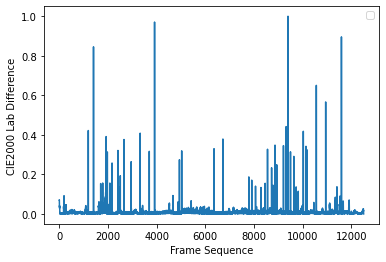

In [ ]:
#CIEDE2000 frame sequence difference 14/03/2021 ORIGINAL PAPER WITH only MEAN as feature
import cv2
import numpy as np
from skimage import color
#from ciede2000 import CIEDE2000
import math
import time
from matplotlib import pyplot as plt
import numpy as np

def CIEDE2000(Lab_1, Lab_2):
    '''Calculates CIEDE2000 color distance between two CIE L*a*b* colors'''
    C_25_7 = 6103515625 # 25**7
    
    L1, a1, b1 = Lab_1[0], Lab_1[1], Lab_1[2]
    L2, a2, b2 = Lab_2[0], Lab_2[1], Lab_2[2]
    C1 = math.sqrt(a1**2 + b1**2)
    C2 = math.sqrt(a2**2 + b2**2)
    C_ave = (C1 + C2) / 2
    G = 0.5 * (1 - math.sqrt(C_ave**7 / (C_ave**7 + C_25_7)))
    
    L1_, L2_ = L1, L2
    a1_, a2_ = (1 + G) * a1, (1 + G) * a2
    b1_, b2_ = b1, b2
    
    C1_ = math.sqrt(a1_**2 + b1_**2)
    C2_ = math.sqrt(a2_**2 + b2_**2)
    
    if b1_ == 0 and a1_ == 0: h1_ = 0
    elif a1_ >= 0: h1_ = math.atan2(b1_, a1_)
    else: h1_ = math.atan2(b1_, a1_) + 2 * math.pi
    
    if b2_ == 0 and a2_ == 0: h2_ = 0
    elif a2_ >= 0: h2_ = math.atan2(b2_, a2_)
    else: h2_ = math.atan2(b2_, a2_) + 2 * math.pi

    dL_ = L2_ - L1_
    dC_ = C2_ - C1_    
    dh_ = h2_ - h1_
    if C1_ * C2_ == 0: dh_ = 0
    elif dh_ > math.pi: dh_ -= 2 * math.pi
    elif dh_ < -math.pi: dh_ += 2 * math.pi        
    dH_ = 2 * math.sqrt(C1_ * C2_) * math.sin(dh_ / 2)
    
    L_ave = (L1_ + L2_) / 2
    C_ave = (C1_ + C2_) / 2
    
    _dh = abs(h1_ - h2_)
    _sh = h1_ + h2_
    C1C2 = C1_ * C2_
    
    if _dh <= math.pi and C1C2 != 0: h_ave = (h1_ + h2_) / 2
    elif _dh  > math.pi and _sh < 2 * math.pi and C1C2 != 0: h_ave = (h1_ + h2_) / 2 + math.pi
    elif _dh  > math.pi and _sh >= 2 * math.pi and C1C2 != 0: h_ave = (h1_ + h2_) / 2 - math.pi 
    else: h_ave = h1_ + h2_
    
    T = 1 - 0.17 * math.cos(h_ave - math.pi / 6) + 0.24 * math.cos(2 * h_ave) + 0.32 * math.cos(3 * h_ave + math.pi / 30) - 0.2 * math.cos(4 * h_ave - 63 * math.pi / 180)
    
    h_ave_deg = h_ave * 180 / math.pi
    if h_ave_deg < 0: h_ave_deg += 360
    elif h_ave_deg > 360: h_ave_deg -= 360
    dTheta = 30 * math.exp(-(((h_ave_deg - 275) / 25)**2))
    
    R_C = 2 * math.sqrt(C_ave**7 / (C_ave**7 + C_25_7))  
    S_C = 1 + 0.045 * C_ave
    S_H = 1 + 0.015 * C_ave * T
    
    Lm50s = (L_ave - 50)**2
    S_L = 1 + 0.015 * Lm50s / math.sqrt(20 + Lm50s)
    R_T = -math.sin(dTheta * math.pi / 90) * R_C

    k_L, k_C, k_H = 1, 1, 1
    
    f_L = dL_ / k_L / S_L
    f_C = dC_ / k_C / S_C
    f_H = dH_ / k_H / S_H
    
    dE_00 = math.sqrt(f_L**2 + f_C**2 + f_H**2 + R_T * f_C * f_H)
    return dE_00
#start time
start = time.time()
frame = []
labdiff = []
for k in range(1,12510):
  image1 = cv2.imread("/content/video_frames/frame_"+ str(k) + ".jpg")
  image2 = cv2.imread("/content/video_frames/frame_"+ str(k+1) + ".jpg")
  image1 = np.float32(image1)
  image1 *= 1./255
  image2 = np.float32(image2)
  image2 *= 1./255

  Lab1 = cv2.cvtColor(image1, cv2.COLOR_BGR2Lab)
  print(Lab1.shape)
  Lab2 = cv2.cvtColor(image2, cv2.COLOR_BGR2Lab)


  L1, a1, b1 = cv2.split(Lab1)
  L2, a2, b2 = cv2.split(Lab2)

  L1m = np.mean(L1)
  a1m = np.mean(a1)
  b1m = np.mean(b1)

  L2m = np.mean(L2)
  a2m = np.mean(a2)
  b2m = np.mean(b2)

#print(np.mean(L1))
#print(a1)
  
  diff = CIEDE2000((L1m, a1m, b1m), (L2m, a2m, b2m))
    #print(CIEDE2000((L1[i][j], a1[i][j], b1[i][j]), (L2[i][j], a2[i][j], b2[i][j])))
  print(k)
  print(k+1)
  print(diff/(60*88*3))
  frame.append(k)
  labdiff.append(diff/(60*88*3))
#print(CIEDE2000((50, 2.6772, -79.7751), (50, 0.0000, -82.7485)))


#plt.plot([0.1, 0.2, 0.3, 0.4], [1, 2, 3, 4])
#plt.plot([0.1, 0.2, 0.3, 0.4], [1, 4, 9, 16])
frame = np.array(frame)
labdiff = np.array(labdiff)#*(240*352*3)
labdiff = labdiff/max(labdiff)
print(max(labdiff))
print(labdiff)
plt.plot(frame, (labdiff))#, label='CIEDE2000 Lab Difference')
plt.xlabel("Frame Sequence")
plt.ylabel("CIE2000 Lab Difference")
plt.legend()
#plt.savefig('labdiff.jpeg')
#print(labdiff[11732]*3)
#print(labdiff[11733]*3)
#print(labdiff[11734]*3)

ab_cut = []
deli = 0.22
#labdiff = labdiff*max(labdiff)
for i in range(2,len(frame)):
  if(labdiff[i] > deli):
    if(labdiff[i-1] < deli):
      if(labdiff[i+1] < deli):
        ab_cut.append(i+139)

print(len(ab_cut))
print(ab_cut)
ab_cut = np.array(ab_cut)
print(ab_cut)
#print(ab_cut[0])

sl = []
with open("/content/ab_cut_gt.txt", 'r') as fileobj:
    for row in fileobj:
      sl.append(row.rstrip('\n'))
        #print( row.rstrip('\n') )
print(sl)
print(len(sl))
sl = np.array(sl)
print(sl[0])

gt = []

for i in range(0,len(sl)):
  gt.append(np.int(sl[i]))

print(gt)


TP = 0
FN = 0
FP = 0

num = 0

for i in range(0, len(gt)):
  num = gt[i]
  if num in ab_cut:
    TP = TP + 1
  else:
    FN = FN + 1

for i in range(0,len(ab_cut)):
  num = ab_cut[i]
  if num in gt:
    TP = TP + 1
  else:
    FP = FP + 1




Recall = TP/(TP+FN)

Precision = TP/(TP + FP)

F1 = 2*(Recall*Precision)/(Precision + Recall)
print("RECALL")
print(Recall)

print("PRECISION")
print(Precision)

print("F1 Score")
print(F1)





# end time
end = time.time()

# total time taken
print(f"Runtime of the program is {end - start}")




Streaming output truncated to the last 5000 lines.
(60, 88, 3)
11230
11231
5.7788228426910045e-06
(60, 88, 3)
11231
11232
1.8985157869491407e-05
(60, 88, 3)
11232
11233
4.3558818177978905e-05
(60, 88, 3)
11233
11234
2.140111686373271e-05
(60, 88, 3)
11234
11235
2.0816736965803973e-05
(60, 88, 3)
11235
11236
1.0365975318284248e-05
(60, 88, 3)
11236
11237
4.817055800974859e-06
(60, 88, 3)
11237
11238
1.5512316442023606e-05
(60, 88, 3)
11238
11239
2.0958721290689633e-05
(60, 88, 3)
11239
11240
2.1209392574607794e-05
(60, 88, 3)
11240
11241
4.267703197256436e-06
(60, 88, 3)
11241
11242
1.4545359745565584e-05
(60, 88, 3)
11242
11243
3.989969961581269e-06
(60, 88, 3)
11243
11244
1.823403504438907e-05
(60, 88, 3)
11244
11245
2.1874861882844548e-05
(60, 88, 3)
11245
11246
4.344849176010984e-06
(60, 88, 3)
11246
11247
1.9747836159675173e-05
(60, 88, 3)
11247
11248
3.2806954392222306e-05
(60, 88, 3)
11248
11249
4.334881210701461e-06
(60, 88, 3)
11249
11250
2.4216720261461655e-05
(60, 88, 3)
1125

No handles with labels found to put in legend.


(60, 88, 3)
12480
12481
2.6516739182332007e-05
(60, 88, 3)
12481
12482
3.825686410353628e-05
(60, 88, 3)
12482
12483
3.3011424125427466e-05
(60, 88, 3)
12483
12484
3.465756161200481e-05
(60, 88, 3)
12484
12485
4.20517799601076e-05
(60, 88, 3)
12485
12486
3.6544341897266135e-05
(60, 88, 3)
12486
12487
2.6830108184983228e-05
(60, 88, 3)
12487
12488
4.244841073717656e-05
(60, 88, 3)
12488
12489
3.792297213853006e-05
(60, 88, 3)
12489
12490
2.7864286020252712e-05
(60, 88, 3)
12490
12491
4.9152329651820096e-05
(60, 88, 3)
12491
12492
4.3208342535928844e-05
(60, 88, 3)
12492
12493
2.2508469627096558e-05
(60, 88, 3)
12493
12494
4.2613381000503574e-05
(60, 88, 3)
12494
12495
4.1243349203408565e-05
(60, 88, 3)
12495
12496
2.118003331242474e-05
(60, 88, 3)
12496
12497
5.488811234781795e-05
(60, 88, 3)
12497
12498
3.217550079814526e-05
(60, 88, 3)
12498
12499
3.275341098664274e-05
(60, 88, 3)
12499
12500
3.724307164772593e-05
(60, 88, 3)
12500
12501
2.9419597445071088e-05
(60, 88, 3)
12501
12502


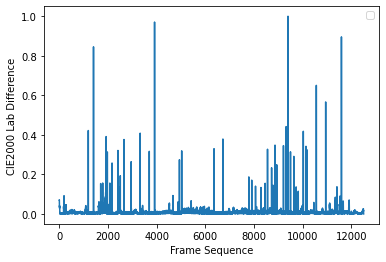

In [ ]:
#CIEDE2000 frame sequence difference 14/03/2021 ORIGINAL PAPER WITH only MEAN as feature 
#and threshold calculation based on Bendrao[2017]
import cv2
import numpy as np
from skimage import color
#from ciede2000 import CIEDE2000
import math
import time
from matplotlib import pyplot as plt
import numpy as np

def CIEDE2000(Lab_1, Lab_2):
    '''Calculates CIEDE2000 color distance between two CIE L*a*b* colors'''
    C_25_7 = 6103515625 # 25**7
    
    L1, a1, b1 = Lab_1[0], Lab_1[1], Lab_1[2]
    L2, a2, b2 = Lab_2[0], Lab_2[1], Lab_2[2]
    C1 = math.sqrt(a1**2 + b1**2)
    C2 = math.sqrt(a2**2 + b2**2)
    C_ave = (C1 + C2) / 2
    G = 0.5 * (1 - math.sqrt(C_ave**7 / (C_ave**7 + C_25_7)))
    
    L1_, L2_ = L1, L2
    a1_, a2_ = (1 + G) * a1, (1 + G) * a2
    b1_, b2_ = b1, b2
    
    C1_ = math.sqrt(a1_**2 + b1_**2)
    C2_ = math.sqrt(a2_**2 + b2_**2)
    
    if b1_ == 0 and a1_ == 0: h1_ = 0
    elif a1_ >= 0: h1_ = math.atan2(b1_, a1_)
    else: h1_ = math.atan2(b1_, a1_) + 2 * math.pi
    
    if b2_ == 0 and a2_ == 0: h2_ = 0
    elif a2_ >= 0: h2_ = math.atan2(b2_, a2_)
    else: h2_ = math.atan2(b2_, a2_) + 2 * math.pi

    dL_ = L2_ - L1_
    dC_ = C2_ - C1_    
    dh_ = h2_ - h1_
    if C1_ * C2_ == 0: dh_ = 0
    elif dh_ > math.pi: dh_ -= 2 * math.pi
    elif dh_ < -math.pi: dh_ += 2 * math.pi        
    dH_ = 2 * math.sqrt(C1_ * C2_) * math.sin(dh_ / 2)
    
    L_ave = (L1_ + L2_) / 2
    C_ave = (C1_ + C2_) / 2
    
    _dh = abs(h1_ - h2_)
    _sh = h1_ + h2_
    C1C2 = C1_ * C2_
    
    if _dh <= math.pi and C1C2 != 0: h_ave = (h1_ + h2_) / 2
    elif _dh  > math.pi and _sh < 2 * math.pi and C1C2 != 0: h_ave = (h1_ + h2_) / 2 + math.pi
    elif _dh  > math.pi and _sh >= 2 * math.pi and C1C2 != 0: h_ave = (h1_ + h2_) / 2 - math.pi 
    else: h_ave = h1_ + h2_
    
    T = 1 - 0.17 * math.cos(h_ave - math.pi / 6) + 0.24 * math.cos(2 * h_ave) + 0.32 * math.cos(3 * h_ave + math.pi / 30) - 0.2 * math.cos(4 * h_ave - 63 * math.pi / 180)
    
    h_ave_deg = h_ave * 180 / math.pi
    if h_ave_deg < 0: h_ave_deg += 360
    elif h_ave_deg > 360: h_ave_deg -= 360
    dTheta = 30 * math.exp(-(((h_ave_deg - 275) / 25)**2))
    
    R_C = 2 * math.sqrt(C_ave**7 / (C_ave**7 + C_25_7))  
    S_C = 1 + 0.045 * C_ave
    S_H = 1 + 0.015 * C_ave * T
    
    Lm50s = (L_ave - 50)**2
    S_L = 1 + 0.015 * Lm50s / math.sqrt(20 + Lm50s)
    R_T = -math.sin(dTheta * math.pi / 90) * R_C

    k_L, k_C, k_H = 1, 1, 1
    
    f_L = dL_ / k_L / S_L
    f_C = dC_ / k_C / S_C
    f_H = dH_ / k_H / S_H
    
    dE_00 = math.sqrt(f_L**2 + f_C**2 + f_H**2 + R_T * f_C * f_H)
    return dE_00
#start time
start = time.time()
frame = []
labdiff = []
for k in range(1,12510):
  image1 = cv2.imread("/content/video_frames/frame_"+ str(k) + ".jpg")
  image2 = cv2.imread("/content/video_frames/frame_"+ str(k+1) + ".jpg")
  image1 = np.float32(image1)
  image1 *= 1./255
  image2 = np.float32(image2)
  image2 *= 1./255

  Lab1 = cv2.cvtColor(image1, cv2.COLOR_BGR2Lab)
  print(Lab1.shape)
  Lab2 = cv2.cvtColor(image2, cv2.COLOR_BGR2Lab)


  L1, a1, b1 = cv2.split(Lab1)
  L2, a2, b2 = cv2.split(Lab2)

  L1m = np.mean(L1)
  a1m = np.mean(a1)
  b1m = np.mean(b1)

  L2m = np.mean(L2)
  a2m = np.mean(a2)
  b2m = np.mean(b2)

#print(np.mean(L1))
#print(a1)
  
  diff = CIEDE2000((L1m, a1m, b1m), (L2m, a2m, b2m))
    #print(CIEDE2000((L1[i][j], a1[i][j], b1[i][j]), (L2[i][j], a2[i][j], b2[i][j])))
  print(k)
  print(k+1)
  print(diff/(60*88*3))
  frame.append(k)
  labdiff.append(diff/(60*88*3))
#print(CIEDE2000((50, 2.6772, -79.7751), (50, 0.0000, -82.7485)))


#plt.plot([0.1, 0.2, 0.3, 0.4], [1, 2, 3, 4])
#plt.plot([0.1, 0.2, 0.3, 0.4], [1, 4, 9, 16])
frame = np.array(frame)
labdiff = np.array(labdiff)#*(240*352*3)
labdiff = labdiff/max(labdiff)
print(max(labdiff))
print(labdiff)
plt.plot(frame, (labdiff))#, label='CIEDE2000 Lab Difference')
plt.xlabel("Frame Sequence")
plt.ylabel("CIE2000 Lab Difference")
plt.legend()
#plt.savefig('labdiff.jpeg')
#print(labdiff[11732]*3)
#print(labdiff[11733]*3)
#print(labdiff[11734]*3)

ab_cut = []
alpha = 2.081
cont = np.array(labdiff)
cont = cont/max(cont)

newx = np.mean(cont)
sig = np.std(cont)

T = newx + alpha * sig

ab_cut = []
#deli = 0.22
#labdiff = labdiff*max(labdiff)
for i in range(2,len(frame)):
  if(cont[i] > T):
    ab_cut.append(i+139)
   
print(len(ab_cut))
#print(ab_cut)
ab_cut = np.array(ab_cut)
print(ab_cut)
#print(ab_cut[0])

sl = []
with open("/content/ab_cut_gt.txt", 'r') as fileobj:
    for row in fileobj:
      sl.append(row.rstrip('\n'))
        #print( row.rstrip('\n') )
print(sl)
print(len(sl))
sl = np.array(sl)
print(sl[0])

gt = []

for i in range(0,len(sl)):
  gt.append(np.int(sl[i]))

print(gt)


TP = 0
FN = 0
FP = 0

num = 0

for i in range(0, len(gt)):
  num = gt[i]
  if num in ab_cut:
    TP = TP + 1
  else:
    FN = FN + 1

for i in range(0,len(ab_cut)):
  num = ab_cut[i]
  if num in gt:
    TP = TP + 1
  else:
    FP = FP + 1




Recall = TP/(TP+FN)

Precision = TP/(TP + FP)

F1 = 2*(Recall*Precision)/(Precision + Recall)
print("RECALL")
print(Recall)

print("PRECISION")
print(Precision)

print("F1 Score")
print(F1)





# end time
end = time.time()

# total time taken
print(f"Runtime of the program is {end - start}")




Streaming output truncated to the last 5000 lines.
11261
6.736037310692622e-06
(60, 88, 3)
11261
11262
4.739949667645619e-06
(60, 88, 3)
11262
11263
7.61083669941564e-06
(60, 88, 3)
11263
11264
4.460218168947511e-06
(60, 88, 3)
11264
11265
3.138403881812491e-06
(60, 88, 3)
11265
11266
4.004419760492757e-06
(60, 88, 3)
11266
11267
3.6601528546497975e-06
(60, 88, 3)
11267
11268
5.153333447740042e-06
(60, 88, 3)
11268
11269
8.77494528285394e-06
(60, 88, 3)
11269
11270
9.96914363300291e-06
(60, 88, 3)
11270
11271
4.392722080047915e-06
(60, 88, 3)
11271
11272
3.7509785727819647e-06
(60, 88, 3)
11272
11273
9.925845201079105e-06
(60, 88, 3)
11273
11274
2.0990161456422455e-06
(60, 88, 3)
11274
11275
7.4226839705113396e-06
(60, 88, 3)
11275
11276
7.931656514076556e-06
(60, 88, 3)
11276
11277
6.60019484084229e-06
(60, 88, 3)
11277
11278
3.666141657942565e-06
(60, 88, 3)
11278
11279
1.3363767615409205e-05
(60, 88, 3)
11279
11280
4.427462504425118e-06
(60, 88, 3)
11280
11281
2.2119412229844744e-06

No handles with labels found to put in legend.


39
[1331, 1545, 1840, 2049, 2064, 2113, 2217, 2307, 2549, 2595, 2646, 2797, 3093, 3463, 3837, 4054, 5016, 5076, 5169, 6498, 6863, 8047, 8203, 8244, 8864, 9075, 9351, 9461, 9538, 9640, 9777, 9959, 10167, 10267, 10321, 10702, 11086, 11549, 11734]
[ 1331  1545  1840  2049  2064  2113  2217  2307  2549  2595  2646  2797
  3093  3463  3837  4054  5016  5076  5169  6498  6863  8047  8203  8244
  8864  9075  9351  9461  9538  9640  9777  9959 10167 10267 10321 10702
 11086 11549 11734]
['1331', '1545', '1840', '1923', '2064', '2113', '2217', '2307', '2549', '2646', '2797', '3093', '3463', '3837', '4054', '5016', '5076', '5169', '6288', '6498', '6863', '7928', '8047', '8203', '8244', '8429', '8598', '8696', '8864', '9004', '9075', '9351', '9461', '9538', '9640', '9777', '9872', '9959', '10167', '10267', '10277', '10321', '10702', '11086', '11549', '11734']
46
1331
[1331, 1545, 1840, 1923, 2064, 2113, 2217, 2307, 2549, 2646, 2797, 3093, 3463, 3837, 4054, 5016, 5076, 5169, 6288, 6498, 6863, 7928

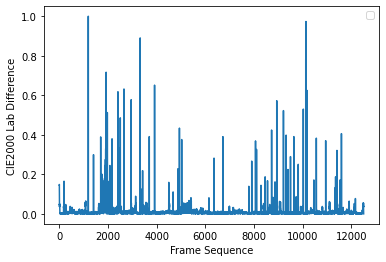

In [ ]:
#CIEDE2000 frame sequence difference 14/03/2021 ORIGINAL PAPER WITH only standard deviation as feature
import cv2
import numpy as np
from skimage import color
#from ciede2000 import CIEDE2000
import math
import time
from matplotlib import pyplot as plt
import numpy as np

def CIEDE2000(Lab_1, Lab_2):
    '''Calculates CIEDE2000 color distance between two CIE L*a*b* colors'''
    C_25_7 = 6103515625 # 25**7
    
    L1, a1, b1 = Lab_1[0], Lab_1[1], Lab_1[2]
    L2, a2, b2 = Lab_2[0], Lab_2[1], Lab_2[2]
    C1 = math.sqrt(a1**2 + b1**2)
    C2 = math.sqrt(a2**2 + b2**2)
    C_ave = (C1 + C2) / 2
    G = 0.5 * (1 - math.sqrt(C_ave**7 / (C_ave**7 + C_25_7)))
    
    L1_, L2_ = L1, L2
    a1_, a2_ = (1 + G) * a1, (1 + G) * a2
    b1_, b2_ = b1, b2
    
    C1_ = math.sqrt(a1_**2 + b1_**2)
    C2_ = math.sqrt(a2_**2 + b2_**2)
    
    if b1_ == 0 and a1_ == 0: h1_ = 0
    elif a1_ >= 0: h1_ = math.atan2(b1_, a1_)
    else: h1_ = math.atan2(b1_, a1_) + 2 * math.pi
    
    if b2_ == 0 and a2_ == 0: h2_ = 0
    elif a2_ >= 0: h2_ = math.atan2(b2_, a2_)
    else: h2_ = math.atan2(b2_, a2_) + 2 * math.pi

    dL_ = L2_ - L1_
    dC_ = C2_ - C1_    
    dh_ = h2_ - h1_
    if C1_ * C2_ == 0: dh_ = 0
    elif dh_ > math.pi: dh_ -= 2 * math.pi
    elif dh_ < -math.pi: dh_ += 2 * math.pi        
    dH_ = 2 * math.sqrt(C1_ * C2_) * math.sin(dh_ / 2)
    
    L_ave = (L1_ + L2_) / 2
    C_ave = (C1_ + C2_) / 2
    
    _dh = abs(h1_ - h2_)
    _sh = h1_ + h2_
    C1C2 = C1_ * C2_
    
    if _dh <= math.pi and C1C2 != 0: h_ave = (h1_ + h2_) / 2
    elif _dh  > math.pi and _sh < 2 * math.pi and C1C2 != 0: h_ave = (h1_ + h2_) / 2 + math.pi
    elif _dh  > math.pi and _sh >= 2 * math.pi and C1C2 != 0: h_ave = (h1_ + h2_) / 2 - math.pi 
    else: h_ave = h1_ + h2_
    
    T = 1 - 0.17 * math.cos(h_ave - math.pi / 6) + 0.24 * math.cos(2 * h_ave) + 0.32 * math.cos(3 * h_ave + math.pi / 30) - 0.2 * math.cos(4 * h_ave - 63 * math.pi / 180)
    
    h_ave_deg = h_ave * 180 / math.pi
    if h_ave_deg < 0: h_ave_deg += 360
    elif h_ave_deg > 360: h_ave_deg -= 360
    dTheta = 30 * math.exp(-(((h_ave_deg - 275) / 25)**2))
    
    R_C = 2 * math.sqrt(C_ave**7 / (C_ave**7 + C_25_7))  
    S_C = 1 + 0.045 * C_ave
    S_H = 1 + 0.015 * C_ave * T
    
    Lm50s = (L_ave - 50)**2
    S_L = 1 + 0.015 * Lm50s / math.sqrt(20 + Lm50s)
    R_T = -math.sin(dTheta * math.pi / 90) * R_C

    k_L, k_C, k_H = 1, 1, 1
    
    f_L = dL_ / k_L / S_L
    f_C = dC_ / k_C / S_C
    f_H = dH_ / k_H / S_H
    
    dE_00 = math.sqrt(f_L**2 + f_C**2 + f_H**2 + R_T * f_C * f_H)
    return dE_00
#start time
start = time.time()
frame = []
labdiff = []
for k in range(1,12510):
  image1 = cv2.imread("/content/video_frames/frame_"+ str(k) + ".jpg")
  image2 = cv2.imread("/content/video_frames/frame_"+ str(k+1) + ".jpg")
  image1 = np.float32(image1)
  image1 *= 1./255
  image2 = np.float32(image2)
  image2 *= 1./255

  Lab1 = cv2.cvtColor(image1, cv2.COLOR_BGR2Lab)
  print(Lab1.shape)
  Lab2 = cv2.cvtColor(image2, cv2.COLOR_BGR2Lab)


  L1, a1, b1 = cv2.split(Lab1)
  L2, a2, b2 = cv2.split(Lab2)

  L1m = np.std(L1)
  a1m = np.std(a1)
  b1m = np.std(b1)

  L2m = np.std(L2)
  a2m = np.std(a2)
  b2m = np.std(b2)

#print(np.mean(L1))
#print(a1)
  
  diff = CIEDE2000((L1m, a1m, b1m), (L2m, a2m, b2m))
    #print(CIEDE2000((L1[i][j], a1[i][j], b1[i][j]), (L2[i][j], a2[i][j], b2[i][j])))
  print(k)
  print(k+1)
  print(diff/(60*88*3))
  frame.append(k)
  labdiff.append(diff/(60*88*3))
#print(CIEDE2000((50, 2.6772, -79.7751), (50, 0.0000, -82.7485)))


#plt.plot([0.1, 0.2, 0.3, 0.4], [1, 2, 3, 4])
#plt.plot([0.1, 0.2, 0.3, 0.4], [1, 4, 9, 16])
frame = np.array(frame)
labdiff = np.array(labdiff)#*(240*352*3)
labdiff = labdiff/max(labdiff)
print(max(labdiff))
print(labdiff)
plt.plot(frame, (labdiff))#, label='CIEDE2000 Lab Difference')
plt.xlabel("Frame Sequence")
plt.ylabel("CIE2000 Lab Difference")
plt.legend()
#plt.savefig('labdiff.jpeg')
#print(labdiff[11732]*3)
#print(labdiff[11733]*3)
#print(labdiff[11734]*3)

ab_cut = []
deli = 0.22
#labdiff = labdiff*max(labdiff)
for i in range(2,len(frame)):
  if(labdiff[i] > deli):
    if(labdiff[i-1] < deli):
      if(labdiff[i+1] < deli):
        ab_cut.append(i+139)

print(len(ab_cut))
print(ab_cut)
ab_cut = np.array(ab_cut)
print(ab_cut)
#print(ab_cut[0])

sl = []
with open("/content/ab_cut_gt.txt", 'r') as fileobj:
    for row in fileobj:
      sl.append(row.rstrip('\n'))
        #print( row.rstrip('\n') )
print(sl)
print(len(sl))
sl = np.array(sl)
print(sl[0])

gt = []

for i in range(0,len(sl)):
  gt.append(np.int(sl[i]))

print(gt)


TP = 0
FN = 0
FP = 0

num = 0

for i in range(0, len(gt)):
  num = gt[i]
  if num in ab_cut:
    TP = TP + 1
  else:
    FN = FN + 1

for i in range(0,len(ab_cut)):
  num = ab_cut[i]
  if num in gt:
    TP = TP + 1
  else:
    FP = FP + 1




Recall = TP/(TP+FN)

Precision = TP/(TP + FP)

F1 = 2*(Recall*Precision)/(Precision + Recall)
print("RECALL")
print(Recall)

print("PRECISION")
print(Precision)

print("F1 Score")
print(F1)





# end time
end = time.time()

# total time taken
print(f"Runtime of the program is {end - start}")




Streaming output truncated to the last 5000 lines.
11160
11161
4.8861433111755685e-06
(60, 88, 3)
11161
11162
3.360881742976652e-06
(60, 88, 3)
11162
11163
6.498439405146809e-06
(60, 88, 3)
11163
11164
6.967192925632629e-06
(60, 88, 3)
11164
11165
3.772782611245246e-06
(60, 88, 3)
11165
11166
1.6628152190302315e-06
(60, 88, 3)
11166
11167
1.0238384358143765e-05
(60, 88, 3)
11167
11168
5.15622261765816e-06
(60, 88, 3)
11168
11169
5.725615595912557e-06
(60, 88, 3)
11169
11170
1.349319386207007e-05
(60, 88, 3)
11170
11171
2.9618821237921033e-06
(60, 88, 3)
11171
11172
6.9296590249328665e-06
(60, 88, 3)
11172
11173
8.575236547570887e-06
(60, 88, 3)
11173
11174
6.620678405374849e-06
(60, 88, 3)
11174
11175
9.62703215275539e-06
(60, 88, 3)
11175
11176
3.7977410521262637e-06
(60, 88, 3)
11176
11177
8.633560112204446e-06
(60, 88, 3)
11177
11178
5.161858359981492e-06
(60, 88, 3)
11178
11179
8.832246862528215e-06
(60, 88, 3)
11179
11180
7.363391682033664e-06
(60, 88, 3)
11180
11181
2.53537226341

No handles with labels found to put in legend.


12410
12411
2.886056370579407e-06
(60, 88, 3)
12411
12412
1.0432574042011067e-06
(60, 88, 3)
12412
12413
2.5202723809938488e-06
(60, 88, 3)
12413
12414
2.776068268692849e-06
(60, 88, 3)
12414
12415
2.538564187676551e-06
(60, 88, 3)
12415
12416
2.0844225373474963e-06
(60, 88, 3)
12416
12417
1.924367756067839e-06
(60, 88, 3)
12417
12418
2.3065566480916294e-06
(60, 88, 3)
12418
12419
1.695113267134723e-06
(60, 88, 3)
12419
12420
1.653941530776676e-06
(60, 88, 3)
12420
12421
1.4207965826292024e-06
(60, 88, 3)
12421
12422
3.954658506910595e-06
(60, 88, 3)
12422
12423
4.989702478770647e-06
(60, 88, 3)
12423
12424
1.2104685410726869e-06
(60, 88, 3)
12424
12425
1.400664689070012e-06
(60, 88, 3)
12425
12426
2.786245614827389e-06
(60, 88, 3)
12426
12427
3.864365001519085e-06
(60, 88, 3)
12427
12428
1.4295537223337008e-06
(60, 88, 3)
12428
12429
2.17767814284602e-06
(60, 88, 3)
12429
12430
2.0079094991976163e-06
(60, 88, 3)
12430
12431
1.6890592458621143e-06
(60, 88, 3)
12431
12432
2.716580118519

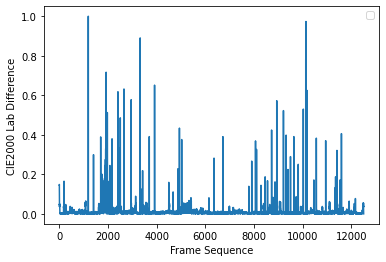

In [ ]:
#CIEDE2000 frame sequence difference 14/03/2021 ORIGINAL PAPER WITH only standard deviation as feature
#with threshold criteria as Bendrao et. al[2017]
import cv2
import numpy as np
from skimage import color
#from ciede2000 import CIEDE2000
import math
import time
from matplotlib import pyplot as plt
import numpy as np

def CIEDE2000(Lab_1, Lab_2):
    '''Calculates CIEDE2000 color distance between two CIE L*a*b* colors'''
    C_25_7 = 6103515625 # 25**7
    
    L1, a1, b1 = Lab_1[0], Lab_1[1], Lab_1[2]
    L2, a2, b2 = Lab_2[0], Lab_2[1], Lab_2[2]
    C1 = math.sqrt(a1**2 + b1**2)
    C2 = math.sqrt(a2**2 + b2**2)
    C_ave = (C1 + C2) / 2
    G = 0.5 * (1 - math.sqrt(C_ave**7 / (C_ave**7 + C_25_7)))
    
    L1_, L2_ = L1, L2
    a1_, a2_ = (1 + G) * a1, (1 + G) * a2
    b1_, b2_ = b1, b2
    
    C1_ = math.sqrt(a1_**2 + b1_**2)
    C2_ = math.sqrt(a2_**2 + b2_**2)
    
    if b1_ == 0 and a1_ == 0: h1_ = 0
    elif a1_ >= 0: h1_ = math.atan2(b1_, a1_)
    else: h1_ = math.atan2(b1_, a1_) + 2 * math.pi
    
    if b2_ == 0 and a2_ == 0: h2_ = 0
    elif a2_ >= 0: h2_ = math.atan2(b2_, a2_)
    else: h2_ = math.atan2(b2_, a2_) + 2 * math.pi

    dL_ = L2_ - L1_
    dC_ = C2_ - C1_    
    dh_ = h2_ - h1_
    if C1_ * C2_ == 0: dh_ = 0
    elif dh_ > math.pi: dh_ -= 2 * math.pi
    elif dh_ < -math.pi: dh_ += 2 * math.pi        
    dH_ = 2 * math.sqrt(C1_ * C2_) * math.sin(dh_ / 2)
    
    L_ave = (L1_ + L2_) / 2
    C_ave = (C1_ + C2_) / 2
    
    _dh = abs(h1_ - h2_)
    _sh = h1_ + h2_
    C1C2 = C1_ * C2_
    
    if _dh <= math.pi and C1C2 != 0: h_ave = (h1_ + h2_) / 2
    elif _dh  > math.pi and _sh < 2 * math.pi and C1C2 != 0: h_ave = (h1_ + h2_) / 2 + math.pi
    elif _dh  > math.pi and _sh >= 2 * math.pi and C1C2 != 0: h_ave = (h1_ + h2_) / 2 - math.pi 
    else: h_ave = h1_ + h2_
    
    T = 1 - 0.17 * math.cos(h_ave - math.pi / 6) + 0.24 * math.cos(2 * h_ave) + 0.32 * math.cos(3 * h_ave + math.pi / 30) - 0.2 * math.cos(4 * h_ave - 63 * math.pi / 180)
    
    h_ave_deg = h_ave * 180 / math.pi
    if h_ave_deg < 0: h_ave_deg += 360
    elif h_ave_deg > 360: h_ave_deg -= 360
    dTheta = 30 * math.exp(-(((h_ave_deg - 275) / 25)**2))
    
    R_C = 2 * math.sqrt(C_ave**7 / (C_ave**7 + C_25_7))  
    S_C = 1 + 0.045 * C_ave
    S_H = 1 + 0.015 * C_ave * T
    
    Lm50s = (L_ave - 50)**2
    S_L = 1 + 0.015 * Lm50s / math.sqrt(20 + Lm50s)
    R_T = -math.sin(dTheta * math.pi / 90) * R_C

    k_L, k_C, k_H = 1, 1, 1
    
    f_L = dL_ / k_L / S_L
    f_C = dC_ / k_C / S_C
    f_H = dH_ / k_H / S_H
    
    dE_00 = math.sqrt(f_L**2 + f_C**2 + f_H**2 + R_T * f_C * f_H)
    return dE_00
#start time
start = time.time()
frame = []
labdiff = []
for k in range(1,12510):
  image1 = cv2.imread("/content/video_frames/frame_"+ str(k) + ".jpg")
  image2 = cv2.imread("/content/video_frames/frame_"+ str(k+1) + ".jpg")
  image1 = np.float32(image1)
  image1 *= 1./255
  image2 = np.float32(image2)
  image2 *= 1./255

  Lab1 = cv2.cvtColor(image1, cv2.COLOR_BGR2Lab)
  print(Lab1.shape)
  Lab2 = cv2.cvtColor(image2, cv2.COLOR_BGR2Lab)


  L1, a1, b1 = cv2.split(Lab1)
  L2, a2, b2 = cv2.split(Lab2)

  L1m = np.std(L1)
  a1m = np.std(a1)
  b1m = np.std(b1)

  L2m = np.std(L2)
  a2m = np.std(a2)
  b2m = np.std(b2)

#print(np.mean(L1))
#print(a1)
  
  diff = CIEDE2000((L1m, a1m, b1m), (L2m, a2m, b2m))
    #print(CIEDE2000((L1[i][j], a1[i][j], b1[i][j]), (L2[i][j], a2[i][j], b2[i][j])))
  print(k)
  print(k+1)
  print(diff/(60*88*3))
  frame.append(k)
  labdiff.append(diff/(60*88*3))
#print(CIEDE2000((50, 2.6772, -79.7751), (50, 0.0000, -82.7485)))


#plt.plot([0.1, 0.2, 0.3, 0.4], [1, 2, 3, 4])
#plt.plot([0.1, 0.2, 0.3, 0.4], [1, 4, 9, 16])
frame = np.array(frame)
labdiff = np.array(labdiff)#*(240*352*3)
labdiff = labdiff/max(labdiff)
print(max(labdiff))
print(labdiff)
plt.plot(frame, (labdiff))#, label='CIEDE2000 Lab Difference')
plt.xlabel("Frame Sequence")
plt.ylabel("CIE2000 Lab Difference")
plt.legend()
#plt.savefig('labdiff.jpeg')
#print(labdiff[11732]*3)
#print(labdiff[11733]*3)
#print(labdiff[11734]*3)

ab_cut = []
alpha = 2.081
cont = np.array(labdiff)
cont = cont/max(cont)

newx = np.mean(cont)
sig = np.std(cont)

T = newx + alpha * sig

ab_cut = []
#deli = 0.22
#labdiff = labdiff*max(labdiff)
for i in range(2,len(frame)):
  if(cont[i] > T):
    ab_cut.append(i+139)
   
print(len(ab_cut))
#print(ab_cut)
ab_cut = np.array(ab_cut)
#print(ab_cut[0])

sl = []
with open("/content/ab_cut_gt.txt", 'r') as fileobj:
    for row in fileobj:
      sl.append(row.rstrip('\n'))
        #print( row.rstrip('\n') )
print(sl)
print(len(sl))
sl = np.array(sl)
print(sl[0])

gt = []

for i in range(0,len(sl)):
  gt.append(np.int(sl[i]))

print(gt)


TP = 0
FN = 0
FP = 0

num = 0

for i in range(0, len(gt)):
  num = gt[i]
  if num in ab_cut:
    TP = TP + 1
  else:
    FN = FN + 1

for i in range(0,len(ab_cut)):
  num = ab_cut[i]
  if num in gt:
    TP = TP + 1
  else:
    FP = FP + 1




Recall = TP/(TP+FN)

Precision = TP/(TP + FP)

F1 = 2*(Recall*Precision)/(Precision + Recall)
print("RECALL")
print(Recall)

print("PRECISION")
print(Precision)

print("F1 Score")
print(F1)





# end time
end = time.time()

# total time taken
print(f"Runtime of the program is {end - start}")




Streaming output truncated to the last 5000 lines.
2.276126946955642e-05
(60, 88, 3)
11205
11206
1.4060228818155867e-05
(60, 88, 3)
11206
11207
1.9387143512568968e-05
(60, 88, 3)
11207
11208
2.194576238058748e-05
(60, 88, 3)
11208
11209
2.455875430004823e-05
(60, 88, 3)
11209
11210
3.0510178060051994e-05
(60, 88, 3)
11210
11211
5.155935403787492e-06
(60, 88, 3)
11211
11212
3.0788872468954597e-05
(60, 88, 3)
11212
11213
1.9383426453377623e-05
(60, 88, 3)
11213
11214
2.8533466124677335e-05
(60, 88, 3)
11214
11215
1.9437283267789894e-05
(60, 88, 3)
11215
11216
1.0439278757997567e-05
(60, 88, 3)
11216
11217
2.2877350229715727e-05
(60, 88, 3)
11217
11218
6.276283840783005e-05
(60, 88, 3)
11218
11219
3.5259475863605704e-05
(60, 88, 3)
11219
11220
3.456245371882346e-05
(60, 88, 3)
11220
11221
1.1448141452971248e-05
(60, 88, 3)
11221
11222
3.193195180081141e-05
(60, 88, 3)
11222
11223
4.212597369537175e-05
(60, 88, 3)
11223
11224
3.109932886641228e-05
(60, 88, 3)
11224
11225
2.619875631451855e

No handles with labels found to put in legend.



4.3178181444964236e-05
(60, 88, 3)
12455
12456
2.6633885097816152e-05
(60, 88, 3)
12456
12457
3.8659013426818926e-05
(60, 88, 3)
12457
12458
4.6653470694206446e-05
(60, 88, 3)
12458
12459
3.27746281325266e-05
(60, 88, 3)
12459
12460
3.262680443833934e-05
(60, 88, 3)
12460
12461
4.77678616661119e-05
(60, 88, 3)
12461
12462
3.0336575484647758e-05
(60, 88, 3)
12462
12463
3.681499367698731e-05
(60, 88, 3)
12463
12464
5.6020681732551855e-05
(60, 88, 3)
12464
12465
3.559187162711894e-05
(60, 88, 3)
12465
12466
4.3034541079050334e-05
(60, 88, 3)
12466
12467
4.425120864824695e-05
(60, 88, 3)
12467
12468
5.256693625070978e-05
(60, 88, 3)
12468
12469
3.7133221238466225e-05
(60, 88, 3)
12469
12470
5.166234189349416e-05
(60, 88, 3)
12470
12471
4.687981356425053e-05
(60, 88, 3)
12471
12472
4.851779980089467e-05
(60, 88, 3)
12472
12473
5.9890137879481864e-05
(60, 88, 3)
12473
12474
5.174997942132986e-05
(60, 88, 3)
12474
12475
4.589635494838962e-05
(60, 88, 3)
12475
12476
7.234112094464599e-05
(60,

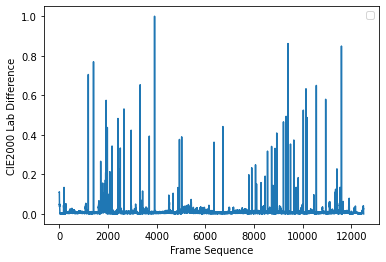

In [ ]:
#CIEDE2000 frame sequence difference 14/03/2021 ORIGINAL PAPER WITH only both mean and standard deviation as feature
import cv2
import numpy as np
from skimage import color
#from ciede2000 import CIEDE2000
import math
import time
from matplotlib import pyplot as plt
import numpy as np

def CIEDE2000(Lab_1, Lab_2):
    '''Calculates CIEDE2000 color distance between two CIE L*a*b* colors'''
    C_25_7 = 6103515625 # 25**7
    
    L1, a1, b1 = Lab_1[0], Lab_1[1], Lab_1[2]
    L2, a2, b2 = Lab_2[0], Lab_2[1], Lab_2[2]
    C1 = math.sqrt(a1**2 + b1**2)
    C2 = math.sqrt(a2**2 + b2**2)
    C_ave = (C1 + C2) / 2
    G = 0.5 * (1 - math.sqrt(C_ave**7 / (C_ave**7 + C_25_7)))
    
    L1_, L2_ = L1, L2
    a1_, a2_ = (1 + G) * a1, (1 + G) * a2
    b1_, b2_ = b1, b2
    
    C1_ = math.sqrt(a1_**2 + b1_**2)
    C2_ = math.sqrt(a2_**2 + b2_**2)
    
    if b1_ == 0 and a1_ == 0: h1_ = 0
    elif a1_ >= 0: h1_ = math.atan2(b1_, a1_)
    else: h1_ = math.atan2(b1_, a1_) + 2 * math.pi
    
    if b2_ == 0 and a2_ == 0: h2_ = 0
    elif a2_ >= 0: h2_ = math.atan2(b2_, a2_)
    else: h2_ = math.atan2(b2_, a2_) + 2 * math.pi

    dL_ = L2_ - L1_
    dC_ = C2_ - C1_    
    dh_ = h2_ - h1_
    if C1_ * C2_ == 0: dh_ = 0
    elif dh_ > math.pi: dh_ -= 2 * math.pi
    elif dh_ < -math.pi: dh_ += 2 * math.pi        
    dH_ = 2 * math.sqrt(C1_ * C2_) * math.sin(dh_ / 2)
    
    L_ave = (L1_ + L2_) / 2
    C_ave = (C1_ + C2_) / 2
    
    _dh = abs(h1_ - h2_)
    _sh = h1_ + h2_
    C1C2 = C1_ * C2_
    
    if _dh <= math.pi and C1C2 != 0: h_ave = (h1_ + h2_) / 2
    elif _dh  > math.pi and _sh < 2 * math.pi and C1C2 != 0: h_ave = (h1_ + h2_) / 2 + math.pi
    elif _dh  > math.pi and _sh >= 2 * math.pi and C1C2 != 0: h_ave = (h1_ + h2_) / 2 - math.pi 
    else: h_ave = h1_ + h2_
    
    T = 1 - 0.17 * math.cos(h_ave - math.pi / 6) + 0.24 * math.cos(2 * h_ave) + 0.32 * math.cos(3 * h_ave + math.pi / 30) - 0.2 * math.cos(4 * h_ave - 63 * math.pi / 180)
    
    h_ave_deg = h_ave * 180 / math.pi
    if h_ave_deg < 0: h_ave_deg += 360
    elif h_ave_deg > 360: h_ave_deg -= 360
    dTheta = 30 * math.exp(-(((h_ave_deg - 275) / 25)**2))
    
    R_C = 2 * math.sqrt(C_ave**7 / (C_ave**7 + C_25_7))  
    S_C = 1 + 0.045 * C_ave
    S_H = 1 + 0.015 * C_ave * T
    
    Lm50s = (L_ave - 50)**2
    S_L = 1 + 0.015 * Lm50s / math.sqrt(20 + Lm50s)
    R_T = -math.sin(dTheta * math.pi / 90) * R_C

    k_L, k_C, k_H = 1, 1, 1
    
    f_L = dL_ / k_L / S_L
    f_C = dC_ / k_C / S_C
    f_H = dH_ / k_H / S_H
    
    dE_00 = math.sqrt(f_L**2 + f_C**2 + f_H**2 + R_T * f_C * f_H)
    return dE_00
#start time
start = time.time()
frame = []
labdiff = []
for k in range(1,12510):
  image1 = cv2.imread("/content/video_frames/frame_"+ str(k) + ".jpg")
  image2 = cv2.imread("/content/video_frames/frame_"+ str(k+1) + ".jpg")
  image1 = np.float32(image1)
  image1 *= 1./255
  image2 = np.float32(image2)
  image2 *= 1./255

  Lab1 = cv2.cvtColor(image1, cv2.COLOR_BGR2Lab)
  print(Lab1.shape)
  Lab2 = cv2.cvtColor(image2, cv2.COLOR_BGR2Lab)


  L1, a1, b1 = cv2.split(Lab1)
  L2, a2, b2 = cv2.split(Lab2)

  Lf1 = []
  af1 = []
  bf1 = []
  Lf2 = []
  af2 = []
  bf2 = []

  L1m = np.std(L1)
  a1m = np.std(a1)
  b1m = np.std(b1)

  Lf1.append(L1m)
  af1.append(a1m)
  bf1.append(b1m)


  L2m = np.std(L2)
  a2m = np.std(a2)
  b2m = np.std(b2)

  Lf2.append(L2m)
  af2.append(a2m)
  bf2.append(b2m)


  L1m = np.mean(L1)
  a1m = np.mean(a1)
  b1m = np.mean(b1)

  Lf1.append(L1m)
  af1.append(a1m)
  bf1.append(b1m)


  L2m = np.mean(L2)
  a2m = np.mean(a2)
  b2m = np.mean(b2)

  Lf2.append(L2m)
  af2.append(a2m)
  bf2.append(b2m)

  Lf1 = np.array(Lf1)
  af1 = np.array(af1)
  bf1 = np.array(bf1)

  Lf2 = np.array(Lf2)
  af2 = np.array(af2)
  bf2 = np.array(bf2)


#print(np.mean(L1))
#print(a1)
  diff = 0
  for i in range(0,len(Lf1)):
    diff = diff + CIEDE2000((Lf1[i], af1[i], bf1[i]), (Lf2[i], af2[i], bf2[i]))
  #diff = CIEDE2000((L1m, a1m, b1m), (L2m, a2m, b2m))
    #print(CIEDE2000((L1[i][j], a1[i][j], b1[i][j]), (L2[i][j], a2[i][j], b2[i][j])))
  print(k)
  print(k+1)
  print(diff/(60*88*3))
  frame.append(k)
  labdiff.append(diff/(60*88*3))
#print(CIEDE2000((50, 2.6772, -79.7751), (50, 0.0000, -82.7485)))


#plt.plot([0.1, 0.2, 0.3, 0.4], [1, 2, 3, 4])
#plt.plot([0.1, 0.2, 0.3, 0.4], [1, 4, 9, 16])
frame = np.array(frame)
labdiff = np.array(labdiff)#*(240*352*3)
labdiff = labdiff/max(labdiff)
print(max(labdiff))
print(labdiff)
plt.plot(frame, (labdiff))#, label='CIEDE2000 Lab Difference')
plt.xlabel("Frame Sequence")
plt.ylabel("CIE2000 Lab Difference")
plt.legend()
#plt.savefig('labdiff.jpeg')
#print(labdiff[11732]*3)
#print(labdiff[11733]*3)
#print(labdiff[11734]*3)

ab_cut = []
deli = 0.22
#labdiff = labdiff*max(labdiff)
for i in range(2,len(frame)):
  if(labdiff[i] > deli):
    if(labdiff[i-1] < deli):
      if(labdiff[i+1] < deli):
        ab_cut.append(i+139)

print(len(ab_cut))
print(ab_cut)
ab_cut = np.array(ab_cut)
print(ab_cut)
#print(ab_cut[0])

sl = []
with open("/content/ab_cut_gt.txt", 'r') as fileobj:
    for row in fileobj:
      sl.append(row.rstrip('\n'))
        #print( row.rstrip('\n') )
print(sl)
print(len(sl))
sl = np.array(sl)
print(sl[0])

gt = []

for i in range(0,len(sl)):
  gt.append(np.int(sl[i]))

print(gt)


TP = 0
FN = 0
FP = 0

num = 0

for i in range(0, len(gt)):
  num = gt[i]
  if num in ab_cut:
    TP = TP + 1
  else:
    FN = FN + 1

for i in range(0,len(ab_cut)):
  num = ab_cut[i]
  if num in gt:
    TP = TP + 1
  else:
    FP = FP + 1




Recall = TP/(TP+FN)

Precision = TP/(TP + FP)

F1 = 2*(Recall*Precision)/(Precision + Recall)
print("RECALL")
print(Recall)

print("PRECISION")
print(Precision)

print("F1 Score")
print(F1)





# end time
end = time.time()

# total time taken
print(f"Runtime of the program is {end - start}")




In [ ]:
#CIEDE2000 frame sequence difference 14/03/2021 ORIGINAL PAPER WITH PCA applied on both mean and standard deviation as feature
import cv2
import numpy as np
from skimage import color
#from ciede2000 import CIEDE2000
import math
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from matplotlib import*
import matplotlib.pyplot as plt
from matplotlib.cm import register_cmap
from scipy import stats
from sklearn.decomposition import PCA as sklearnPCA
from sklearn.cluster import KMeans
import seaborn
import time

def CIEDE2000(Lab_1, Lab_2):
    '''Calculates CIEDE2000 color distance between two CIE L*a*b* colors'''
    C_25_7 = 6103515625 # 25**7
    
    L1, a1, b1 = Lab_1[0], Lab_1[1], Lab_1[2]
    L2, a2, b2 = Lab_2[0], Lab_2[1], Lab_2[2]
    C1 = math.sqrt(a1**2 + b1**2)
    C2 = math.sqrt(a2**2 + b2**2)
    C_ave = (C1 + C2) / 2
    G = 0.5 * (1 - math.sqrt(C_ave**7 / (C_ave**7 + C_25_7)))
    
    L1_, L2_ = L1, L2
    a1_, a2_ = (1 + G) * a1, (1 + G) * a2
    b1_, b2_ = b1, b2
    
    C1_ = math.sqrt(a1_**2 + b1_**2)
    C2_ = math.sqrt(a2_**2 + b2_**2)
    
    if b1_ == 0 and a1_ == 0: h1_ = 0
    elif a1_ >= 0: h1_ = math.atan2(b1_, a1_)
    else: h1_ = math.atan2(b1_, a1_) + 2 * math.pi
    
    if b2_ == 0 and a2_ == 0: h2_ = 0
    elif a2_ >= 0: h2_ = math.atan2(b2_, a2_)
    else: h2_ = math.atan2(b2_, a2_) + 2 * math.pi

    dL_ = L2_ - L1_
    dC_ = C2_ - C1_    
    dh_ = h2_ - h1_
    if C1_ * C2_ == 0: dh_ = 0
    elif dh_ > math.pi: dh_ -= 2 * math.pi
    elif dh_ < -math.pi: dh_ += 2 * math.pi        
    dH_ = 2 * math.sqrt(C1_ * C2_) * math.sin(dh_ / 2)
    
    L_ave = (L1_ + L2_) / 2
    C_ave = (C1_ + C2_) / 2
    
    _dh = abs(h1_ - h2_)
    _sh = h1_ + h2_
    C1C2 = C1_ * C2_
    
    if _dh <= math.pi and C1C2 != 0: h_ave = (h1_ + h2_) / 2
    elif _dh  > math.pi and _sh < 2 * math.pi and C1C2 != 0: h_ave = (h1_ + h2_) / 2 + math.pi
    elif _dh  > math.pi and _sh >= 2 * math.pi and C1C2 != 0: h_ave = (h1_ + h2_) / 2 - math.pi 
    else: h_ave = h1_ + h2_
    
    T = 1 - 0.17 * math.cos(h_ave - math.pi / 6) + 0.24 * math.cos(2 * h_ave) + 0.32 * math.cos(3 * h_ave + math.pi / 30) - 0.2 * math.cos(4 * h_ave - 63 * math.pi / 180)
    
    h_ave_deg = h_ave * 180 / math.pi
    if h_ave_deg < 0: h_ave_deg += 360
    elif h_ave_deg > 360: h_ave_deg -= 360
    dTheta = 30 * math.exp(-(((h_ave_deg - 275) / 25)**2))
    
    R_C = 2 * math.sqrt(C_ave**7 / (C_ave**7 + C_25_7))  
    S_C = 1 + 0.045 * C_ave
    S_H = 1 + 0.015 * C_ave * T
    
    Lm50s = (L_ave - 50)**2
    S_L = 1 + 0.015 * Lm50s / math.sqrt(20 + Lm50s)
    R_T = -math.sin(dTheta * math.pi / 90) * R_C

    k_L, k_C, k_H = 1, 1, 1
    
    f_L = dL_ / k_L / S_L
    f_C = dC_ / k_C / S_C
    f_H = dH_ / k_H / S_H
    
    dE_00 = math.sqrt(f_L**2 + f_C**2 + f_H**2 + R_T * f_C * f_H)
    return dE_00
#start time
start = time.time()
frame = []
labdiff = []
for k in range(1,12510):
  image1 = cv2.imread("/content/video_frames/frame_"+ str(k) + ".jpg")
  image2 = cv2.imread("/content/video_frames/frame_"+ str(k+1) + ".jpg")
  image1 = np.float32(image1)
  image1 *= 1./255
  image2 = np.float32(image2)
  image2 *= 1./255

  Lab1 = cv2.cvtColor(image1, cv2.COLOR_BGR2Lab)
  print(Lab1.shape)
  Lab2 = cv2.cvtColor(image2, cv2.COLOR_BGR2Lab)


  L1, a1, b1 = cv2.split(Lab1)
  L2, a2, b2 = cv2.split(Lab2)

  Lf1 = []
  af1 = []
  bf1 = []
  Lf2 = []
  af2 = []
  bf2 = []

  L1m = np.std(L1)
  a1m = np.std(a1)
  b1m = np.std(b1)

  Lf1.append(L1m)
  af1.append(a1m)
  bf1.append(b1m)
  


  L2m = np.std(L2)
  a2m = np.std(a2)
  b2m = np.std(b2)

  Lf2.append(L2m)
  af2.append(a2m)
  bf2.append(b2m)


  L1m = np.mean(L1)
  a1m = np.mean(a1)
  b1m = np.mean(b1)

  Lf1.append(L1m)
  af1.append(a1m)
  bf1.append(b1m)


  L2m = np.mean(L2)
  a2m = np.mean(a2)
  b2m = np.mean(b2)

  Lf2.append(L2m)
  af2.append(a2m)
  bf2.append(b2m)

  Lf1 = np.array(Lf1)
  af1 = np.array(af1)
  bf1 = np.array(bf1)

  Lf2 = np.array(Lf2)
  af2 = np.array(af2)
  bf2 = np.array(bf2)


#print(np.mean(L1))
#print(a1)
  diff = 0
  for i in range(0,len(Lf1)):
    diff = diff + CIEDE2000((Lf1[i], af1[i], bf1[i]), (Lf2[i], af2[i], bf2[i]))
  #diff = CIEDE2000((L1m, a1m, b1m), (L2m, a2m, b2m))
    #print(CIEDE2000((L1[i][j], a1[i][j], b1[i][j]), (L2[i][j], a2[i][j], b2[i][j])))
  print(k)
  print(k+1)
  print(diff/(60*88*3))
  frame.append(k)
  labdiff.append(diff/(60*88*3))
#print(CIEDE2000((50, 2.6772, -79.7751), (50, 0.0000, -82.7485)))


#plt.plot([0.1, 0.2, 0.3, 0.4], [1, 2, 3, 4])
#plt.plot([0.1, 0.2, 0.3, 0.4], [1, 4, 9, 16])
frame = np.array(frame)
labdiff = np.array(labdiff)#*(240*352*3)
labdiff = labdiff/max(labdiff)
print(max(labdiff))
print(labdiff)
plt.plot(frame, (labdiff))#, label='CIEDE2000 Lab Difference')
plt.xlabel("Frame Sequence")
plt.ylabel("CIE2000 Lab Difference")
plt.legend()
#plt.savefig('labdiff.jpeg')
#print(labdiff[11732]*3)
#print(labdiff[11733]*3)
#print(labdiff[11734]*3)

ab_cut = []
deli = 0.22
#labdiff = labdiff*max(labdiff)
for i in range(2,len(frame)):
  if(labdiff[i] > deli):
    if(labdiff[i-1] < deli):
      if(labdiff[i+1] < deli):
        ab_cut.append(i+139)

print(len(ab_cut))
print(ab_cut)
ab_cut = np.array(ab_cut)
print(ab_cut)
#print(ab_cut[0])

sl = []
with open("/content/ab_cut_gt.txt", 'r') as fileobj:
    for row in fileobj:
      sl.append(row.rstrip('\n'))
        #print( row.rstrip('\n') )
print(sl)
print(len(sl))
sl = np.array(sl)
print(sl[0])

gt = []

for i in range(0,len(sl)):
  gt.append(np.int(sl[i]))

print(gt)


TP = 0
FN = 0
FP = 0

num = 0

for i in range(0, len(gt)):
  num = gt[i]
  if num in ab_cut:
    TP = TP + 1
  else:
    FN = FN + 1

for i in range(0,len(ab_cut)):
  num = ab_cut[i]
  if num in gt:
    TP = TP + 1
  else:
    FP = FP + 1




Recall = TP/(TP+FN)

Precision = TP/(TP + FP)

F1 = 2*(Recall*Precision)/(Precision + Recall)
print("RECALL")
print(Recall)

print("PRECISION")
print(Precision)

print("F1 Score")
print(F1)





# end time
end = time.time()

# total time taken
print(f"Runtime of the program is {end - start}")




error: ignored